In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.data import sciensano
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
agg=None
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')
df = sciensano.get_public_spatial_vaccination_data(agg=agg, update=False)
df = df['INCIDENCE']

## Part 1: N_vacc function

In [3]:
from covid19model.models.time_dependant_parameter_fncs import make_N_vacc_function

In [4]:
# Slice dataset to a moment before the booster campaign
start_booster = '2022-05-02'#'2021-10-04'
df_incidences = df.loc[slice('2020-12-28',start_booster), slice(None), slice(None)]
# Initialize TDPF
output = make_N_vacc_function(agg=agg, df_incidences=df_incidences, hypothetical_function=False)

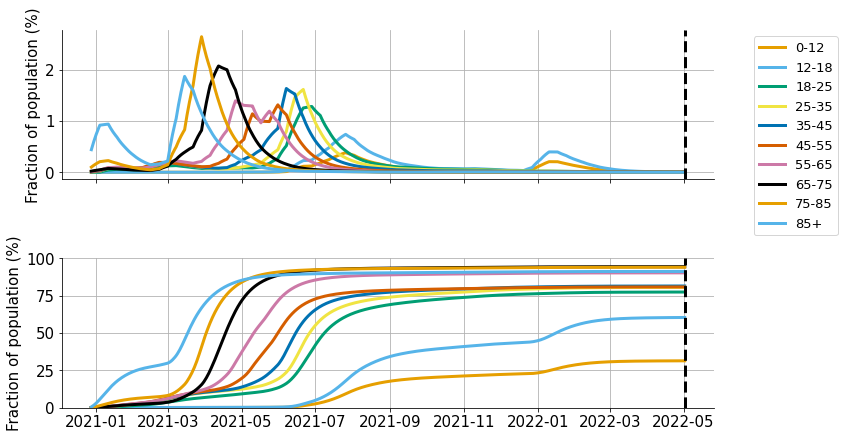

In [5]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = output.df
dose='A'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
#plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()

### Upsample to weekly frequency

In [6]:
groupers=[]
for index_name in df.index.names:
    if index_name != 'date':
        groupers += [pd.Grouper(level=index_name)]
    else:
        groupers += [pd.Grouper(level='date', freq='W-MON')]
df_incidences = df.groupby(groupers).sum()

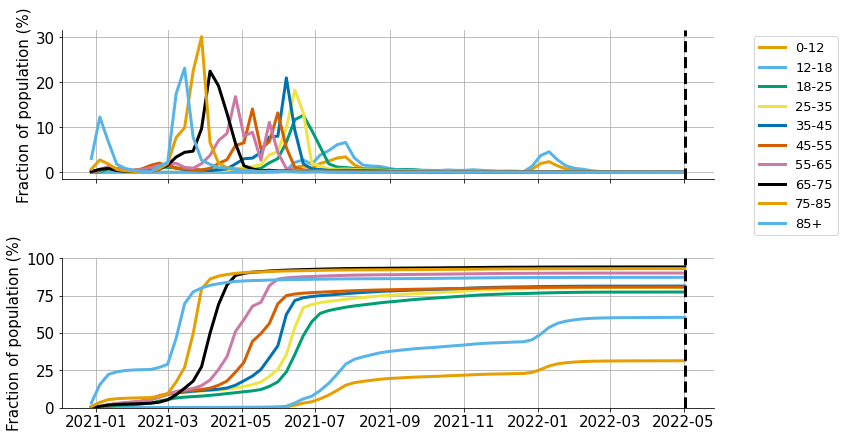

In [7]:
from covid19model.data.model_parameters import construct_initN
N = construct_initN(age_classes, None).values
data = df_incidences
dose='A'

fig,ax=plt.subplots(nrows=2,ncols=1,figsize=(12,6), sharex=True)

for idx, age_class in enumerate(age_classes):
    ax[0].plot(data.loc[slice(None),age_class,dose]/N[idx]*100)
    ax[1].plot(data.loc[slice(None),age_class,dose].cumsum()/N[idx]*100)

ax[0].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')
ax[1].axvline(x=pd.Timestamp(start_booster), color='black', linestyle='--')

ax[0].set_ylabel('Fraction of population (%)')
ax[1].set_ylabel('Fraction of population (%)')

ax[1].set_ylim([0,100])


legend_text=['0-12', '12-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75-85', '85+']
ax[0].legend(legend_text, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

plt.tight_layout()
#plt.savefig('hypothetical_booster_campaign_refusal10_30000.png', dpi=400)
plt.show()
plt.close()

## Part 2: rescaling function for waning

In [8]:
from covid19model.models.time_dependant_parameter_fncs import make_vaccination_rescaling_function
from covid19model.data.model_parameters import get_COVID19_SEIQRD_VOC_parameters

In [9]:
df = df_incidences
update=True
from covid19model.models.time_dependant_parameter_fncs import make_vaccination_efficacy_function
# Load currently saved VOC parameters
VOC_params, vaccine_params = get_COVID19_SEIQRD_VOC_parameters()
function = make_vaccination_efficacy_function(update=update, agg=agg, df_incidences=df, vaccine_params=vaccine_params,
                                              VOCs=['WT', 'abc', 'delta'], age_classes=age_classes)

/tmp/ipykernel_295842/1056231004.py:6: UserWarning: The vaccination rescaling parameters must be updated because a change was made to the vaccination parameters, or the dataframe with incidences was changed/updated. This may take some time.
  function = make_vaccination_efficacy_function(update=update, agg=agg, df_incidences=df, vaccine_params=vaccine_params,
100%|███████████████████████████████████████████| 30/30 [04:32<00:00,  9.08s/it]


In [10]:
df_efficacies=function.df_efficacies
print(df_efficacies.head(5))

efficacy                            e_s   e_i       e_h
date       age     dose    VOC                         
2020-12-28 [0, 12) none    WT     0.000  0.00  0.000000
                           abc    0.000  0.00  0.000000
                           delta  0.000  0.00  0.000000
                   partial WT     0.435  0.31  0.061947
                           abc    0.435  0.31  0.061947


In [11]:
t = pd.Timestamp('2021-01-08')
out = function.e_s(t, {}, {})
print(out[-1,:,:])

[[1.         1.         1.        ]
 [0.57082952 0.57082952 0.61029347]
 [0.13087914 0.13087914 0.21098798]
 [0.13       0.13       0.2       ]]


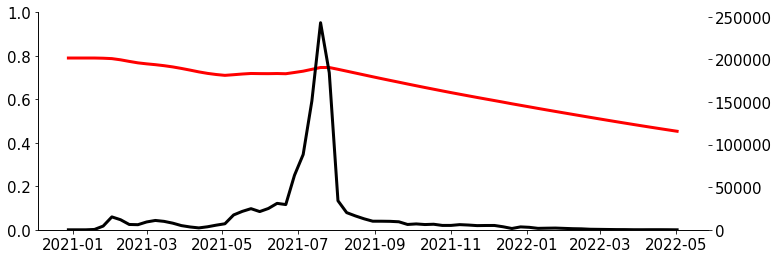

In [17]:
age_class = age_classes[3]
VOC='delta'

fig,ax=plt.subplots(figsize=(12,4))
ax.plot(df_efficacies.loc[(slice(None), age_class, 'full', VOC)]['e_s'], color='red')
ax.set_ylim([0,1])
ax2=ax.twinx()
ax2.plot(df.loc[slice(None),age_class,'B'], color='black')
ax2.set_ylim([0,None])

#ax.plot(df_efficacies.loc[(slice(None), age_class, 'full', VOC)]['e_i'], color='orange')
#ax.plot(df_efficacies.loc[(slice(None), age_class, 'boosted', VOC)]['e_i'], color='green')
ax.grid(False)
ax2.grid(False)
plt.show()
plt.close()

## Part 3: Running the model with both TDPFs

In [13]:
# Number of age groups used in the model
age_stratification_size=10
# Startdate of model
start_date = '2020-03-15'
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date=start_date, update_data=False)

In [14]:
end_sim = '2022-01-01'
out = model.sim(end_sim,start_date=start_date)

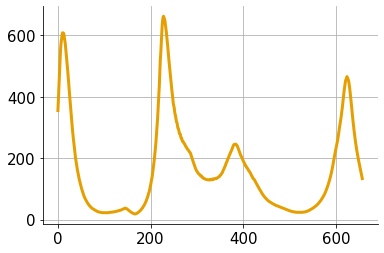

In [15]:
fig,ax=plt.subplots()
ax.plot(out['H_in'].sum(dim='Nc').sum(dim='doses'))
plt.show()
plt.close()